# Final Model

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

### Dependencies

Tested using torch.__version__ = 1.8.0. To install other dependencies run:

In [2]:
import torch 
print(torch.__version__)

1.8.0


```bash
$ pip install --upgrade pip
$ pip install torchvision
$ pip install pycocotools
```

### Helper functions

We modifed some helper functions to simplify training and evaluating detection model. We are using `/references/detection/{engine, utils, transforms}.py` from `pytorch.vision` repository:

```bash
$ git clone https://github.com/pytorch/vision.git
$ mkdir pytorch-helpers
$ cd vision
$ git checkout v0.3.0
$ cp references/detection/utils.py ../pytorch-helpers/
$ cp references/detection/transforms.py ../pytorch-helpers/
$ cp references/detection/coco_eval.py ../pytorch-helpers/
$ cp references/detection/engine.py ../pytorch-helpers/
$ cp references/detection/coco_utils.py ../pytorch-helpers/
$ cd ../pytorch-helpers/
$ chmod +x *
```

### Imports

In [3]:
import os
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

In [4]:
import scipy.io
import torch
import torch.utils.data
import torchvision

In [5]:
# ../src/pytorch-helpers/
module_path = os.path.abspath(os.path.join('../src/pytorch-helpers/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from engine import train_one_epoch, evaluate # test_one_epoch
import utils
import transforms as T

In [6]:
module_path = os.path.abspath(os.path.join('../src/main-model/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import fasterutils
import fasterrcnn

## Data

From:

    * 2975 (2500 with persons) in train (citypersons train) set
    * 500 (441 with persons) in test (citypersons validation) set

we create:

```
anno_train
anno_test

imgs_path_train
imgs_path_test

imgs_paths_train
imgs_paths_test

anno_dict
anno_dict_val

imgs_train
imgs_test
```

In [7]:
imgs_path_train = '../datasets/cityscapes/train/'
imgs_path_test = '../datasets/cityscapes/test/'

In [8]:
anno_dict_train = np.load('anno-all.npy', allow_pickle='TRUE').item()
anno_dict_val = np.load('anno-val.npy', allow_pickle='TRUE').item()
anno_dict = {**anno_dict_train, **anno_dict_val}

In [9]:
## fix the dictionary
cutoff = 100
anno_dict2 = {}
for img in list(anno_dict.keys()):
    bboxes = anno_dict[img]

    bboxes2 = []
    for bbox in bboxes:
        if np.prod(bbox[2:]) > cutoff:
            bboxes2.append(bbox)
    if len(bboxes2) > 0:
        anno_dict2[img] = bboxes2
assert len(anno_dict) == len(anno_dict2), 'images removed'

In [10]:
anno_dict = anno_dict2

In [11]:
imgs1 = os.listdir(imgs_path_train)
imgs2 = list(anno_dict.keys())
imgs3 = list(set(imgs1) & set(imgs2))

anno_train = {}
imgs_train = []
for img in imgs3:
    anno_train[img] = anno_dict[img]
    imgs_train.append(img)

In [12]:
imgs1 = os.listdir(imgs_path_test)
imgs2 = list(anno_dict.keys())
imgs3 = list(set(imgs1) & set(imgs2))

anno_test = {}
imgs_test = []
for img in imgs3:
    anno_test[img] = anno_dict[img]
    imgs_test.append(img)

In [13]:
print('In train: %d, in test: %d.' % (len(imgs_train), len(imgs_test)))

In train: 2315, in test: 418.


In [14]:
i = 0
img_name = imgs_test[i]
img_path = imgs_path_test + img_name
img = Image.open(img_path)
bboxes = anno_test[img_name]

In [15]:
plt.rcParams['figure.figsize'] = [12, 8]

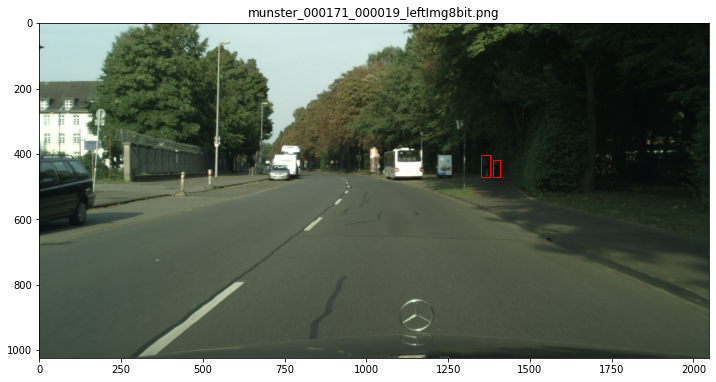

In [16]:
fig, ax = plt.subplots()
ax.imshow(img)

for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

plt.title(img_name)
plt.show()

In [17]:
img_np = np.array(img)
H, W = img_np.shape[:2]
H, W

(1024, 2048)

## Prepare Torch.utils.data.Dataset class for this dataset

In [18]:
imgs_paths_train = [(imgs_path_train + img_name) for img_name in imgs_train]
imgs_paths_test = [(imgs_path_test + img_name) for img_name in imgs_test]

In [20]:
dataset = fasterrcnn.Dataset(imgs_paths_train, imgs_train, anno_train)
dataset_test = fasterrcnn.Dataset(imgs_paths_test, imgs_test, anno_test)

In [21]:
## test it
data = []
for i in range(10):
    data.append(dataset[i])

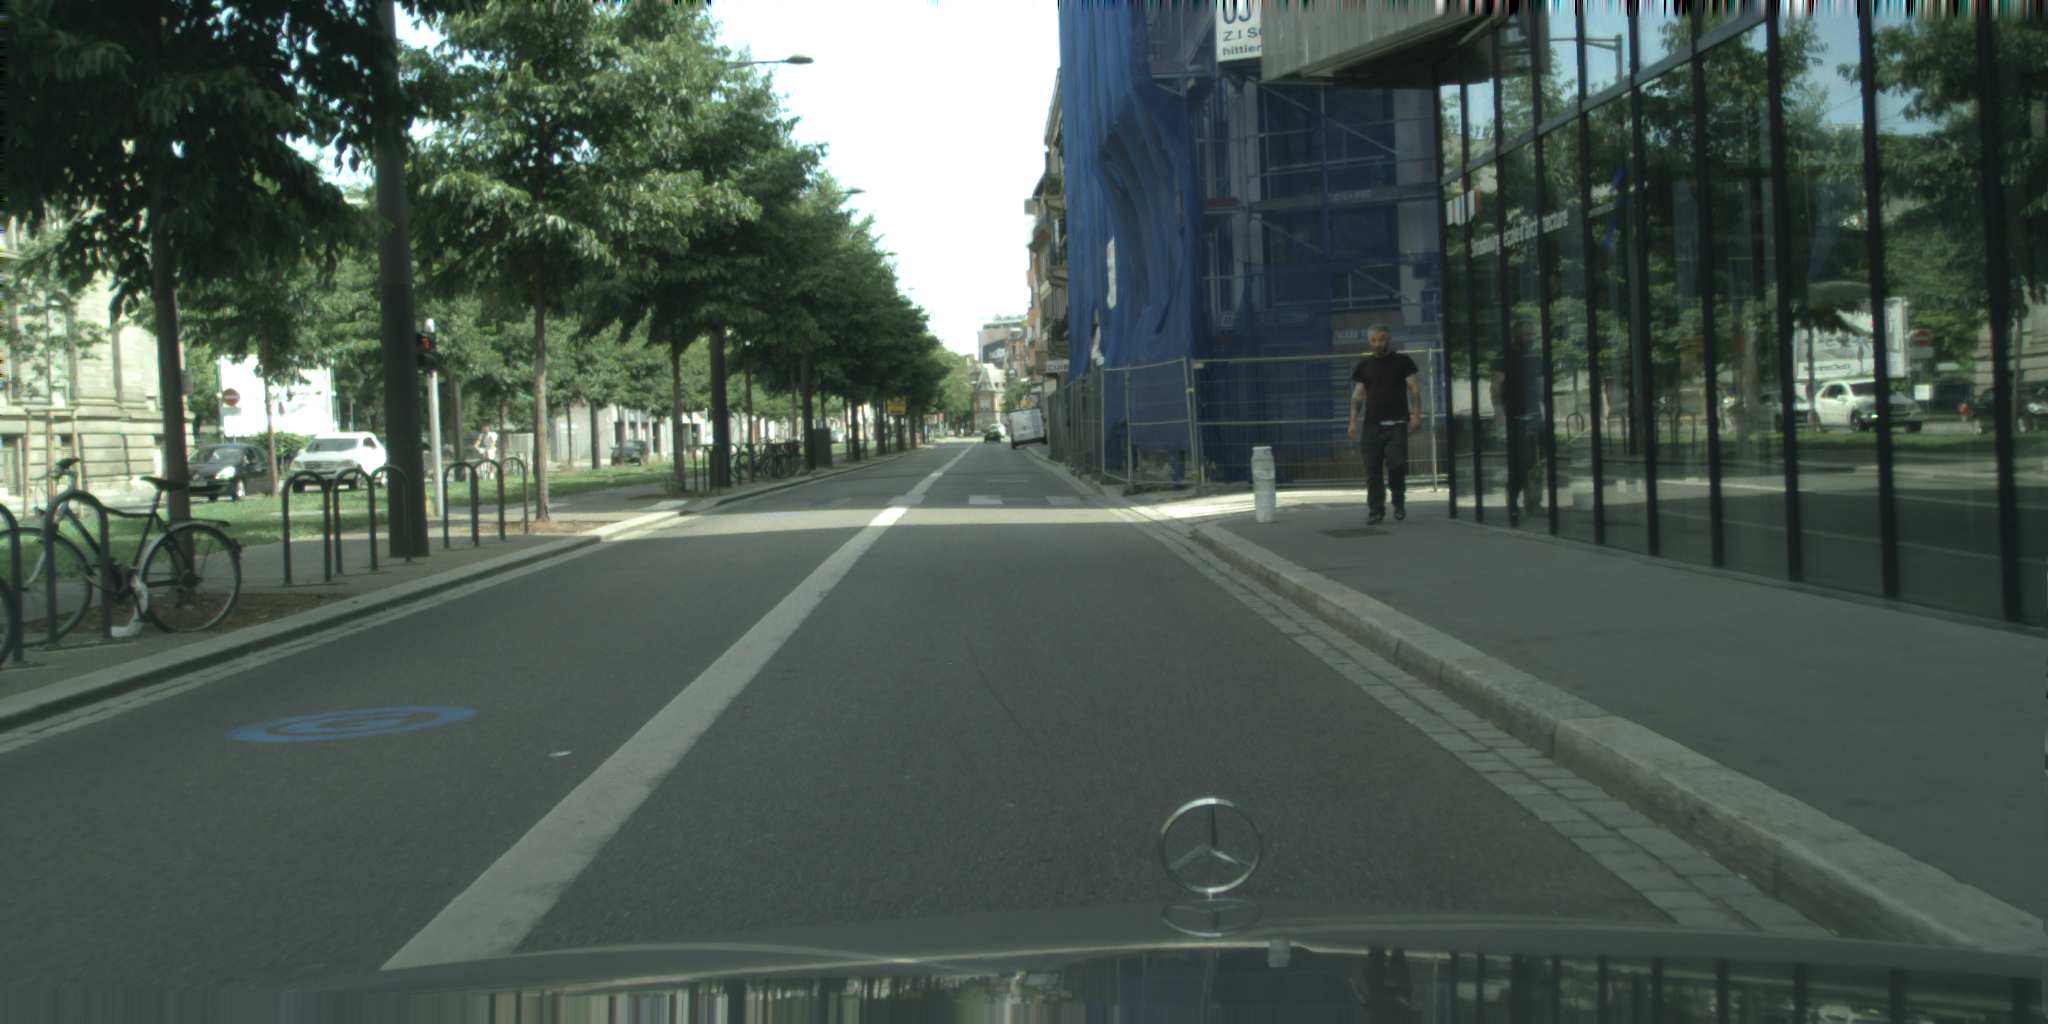

In [22]:
data[0][0]

## Train the model

We do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Faster R-CNN model.

In [23]:
# split the dataset into train and test
dataset = fasterrcnn.Dataset(
    imgs_paths_train,
    imgs_train,
    anno_train, 
    fasterutils.get_transform(train=True))

dataset_test = fasterrcnn.Dataset(
    imgs_paths_test, 
    imgs_test,
    anno_test, 
    fasterutils.get_transform(train=False))

## permute the indices
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

In [24]:
## check it
print(len(indices), len(dataset_test))
# print(dataset[0],  dataset_test[0])

2315 418


In [25]:
## define train and test sets
# dataset = torch.utils.data.Subset(dataset, indices[:-36])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-36:])

## define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0, # changed num_workers to 0
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,  # changed num_workers to 0
    collate_fn=utils.collate_fn)

In [26]:
# check the results
# print('Batch size = %d' % (data_loader.batch_size))
# data_loader.dataset[0], data_loader_test.dataset[0]

In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [28]:
# model = fasterutils.get_model()
model = fasterutils.get_model_anchors()
model.to(device);

In [29]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
## lr, momentum, weight_decay taken from Pedestron:
# https://github.com/hasanirtiza/Pedestron/blob/master/configs/faster_rcnn_r50_fpn_1x.py
optimizer = torch.optim.SGD(params, lr=0.02, momentum=0.9, weight_decay=0.0001)

In [30]:
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

Let's train the model for 10 epochs, evaluating at the end of every epoch.

In [31]:
num_epochs = 10 # total_epochs in Pedestron = 12

tstart = time.time()
all_mean_losses = []
for epoch in range(num_epochs):
    ## train for one epoch, printing every |train|/batch_size iterations
    mean_losses = train_one_epoch(
        model, optimizer, data_loader, device, epoch, 
        print_freq=int(len(dataset)/2))
    
    all_mean_losses.append(mean_losses)
    
    ## update the learning rate
    lr_scheduler.step()
    
    ## evaluate on the test dataset
    evaluator = evaluate(model, data_loader_test, device=device)
    
tend = time.time()

Epoch: [0]  [   0/1158]  eta: 0:09:17  lr: 0.000040  loss: 0.8489 (0.8489)  loss_classifier: 0.5236 (0.5236)  loss_box_reg: 0.2997 (0.2997)  loss_objectness: 0.0173 (0.0173)  loss_rpn_box_reg: 0.0084 (0.0084)  time: 0.4816  data: 0.3643  max mem: 994
Epoch: [0]  [1157/1158]  eta: 0:00:00  lr: 0.020000  loss: 0.3510 (0.4115)  loss_classifier: 0.1107 (0.1262)  loss_box_reg: 0.2107 (0.2288)  loss_objectness: 0.0159 (0.0346)  loss_rpn_box_reg: 0.0116 (0.0218)  time: 0.3551  data: 0.2488  max mem: 1405
Epoch: [0] Total time: 0:07:17 (0.3775 s / it)
creating index...
index created!
Test:  [  0/418]  eta: 0:01:15  model_time: 0.0443 (0.0443)  evaluator_time: 0.0031 (0.0031)  time: 0.1805  data: 0.1294  max mem: 1405
Test:  [100/418]  eta: 0:00:56  model_time: 0.0442 (0.0443)  evaluator_time: 0.0084 (0.0175)  time: 0.1779  data: 0.1119  max mem: 1405
Test:  [200/418]  eta: 0:00:38  model_time: 0.0441 (0.0442)  evaluator_time: 0.0119 (0.0176)  time: 0.1781  data: 0.1104  max mem: 1405
Test:  [3

***Training time on Nvidia Tesla V100 with 16 GB memory***

In [32]:
print('Time elapsed = %.2f min' % ((tend - tstart)/60))

Time elapsed = 92.22 min


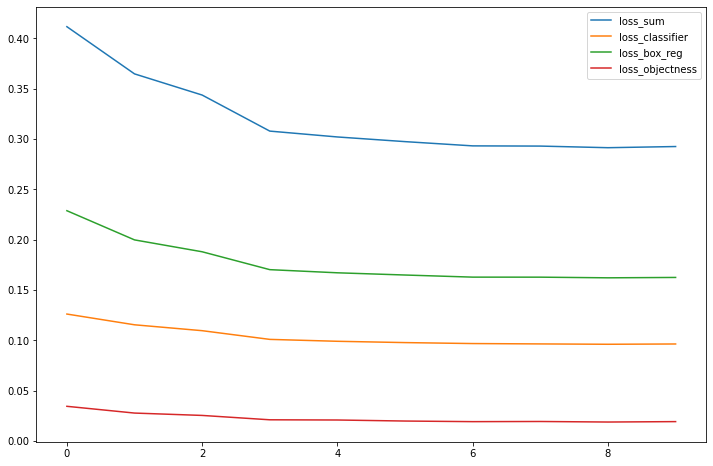

In [33]:
fasterutils.show_losses(all_mean_losses)

Results:
```
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.461
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.754
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.616
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.095
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.663
```

## Error Analysis

### Ground truth

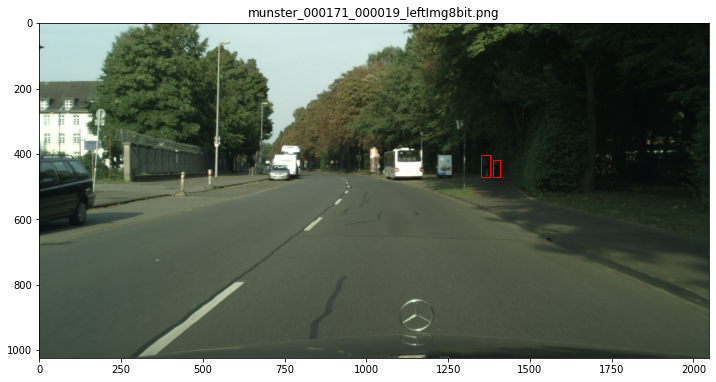

In [34]:
i = 0
img_name = imgs_test[i]
bboxes = anno_test[img_name]

img_path = imgs_path_test + img_name
img = Image.open(img_path)
np_image = np.array(img)

img_raw = img
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()
plt.title('Pedestrians detected')
ax.imshow(img)
for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

plt.title(img_name)
plt.show()

In [35]:
def convert_back(img, img_raw):
    img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    img = np.array(img)
    print('img shape: %d x %d x %d' % img.shape)
    img = Image.fromarray(np.uint8(img)).convert('RGB')

    img_flipped = np.array(img.transpose(Image.FLIP_LEFT_RIGHT))
    img_raw = np.array(img_raw)
    img_was_flipped = np.sum(img_flipped.flatten() == img_raw.flatten()) == img_flipped.shape[0] * img_flipped.shape[1] * img_flipped.shape[2]
    print('Image was flipped: %r' % img_was_flipped)
    
    return img

img shape: 1024 x 2048 x 3
Image was flipped: False


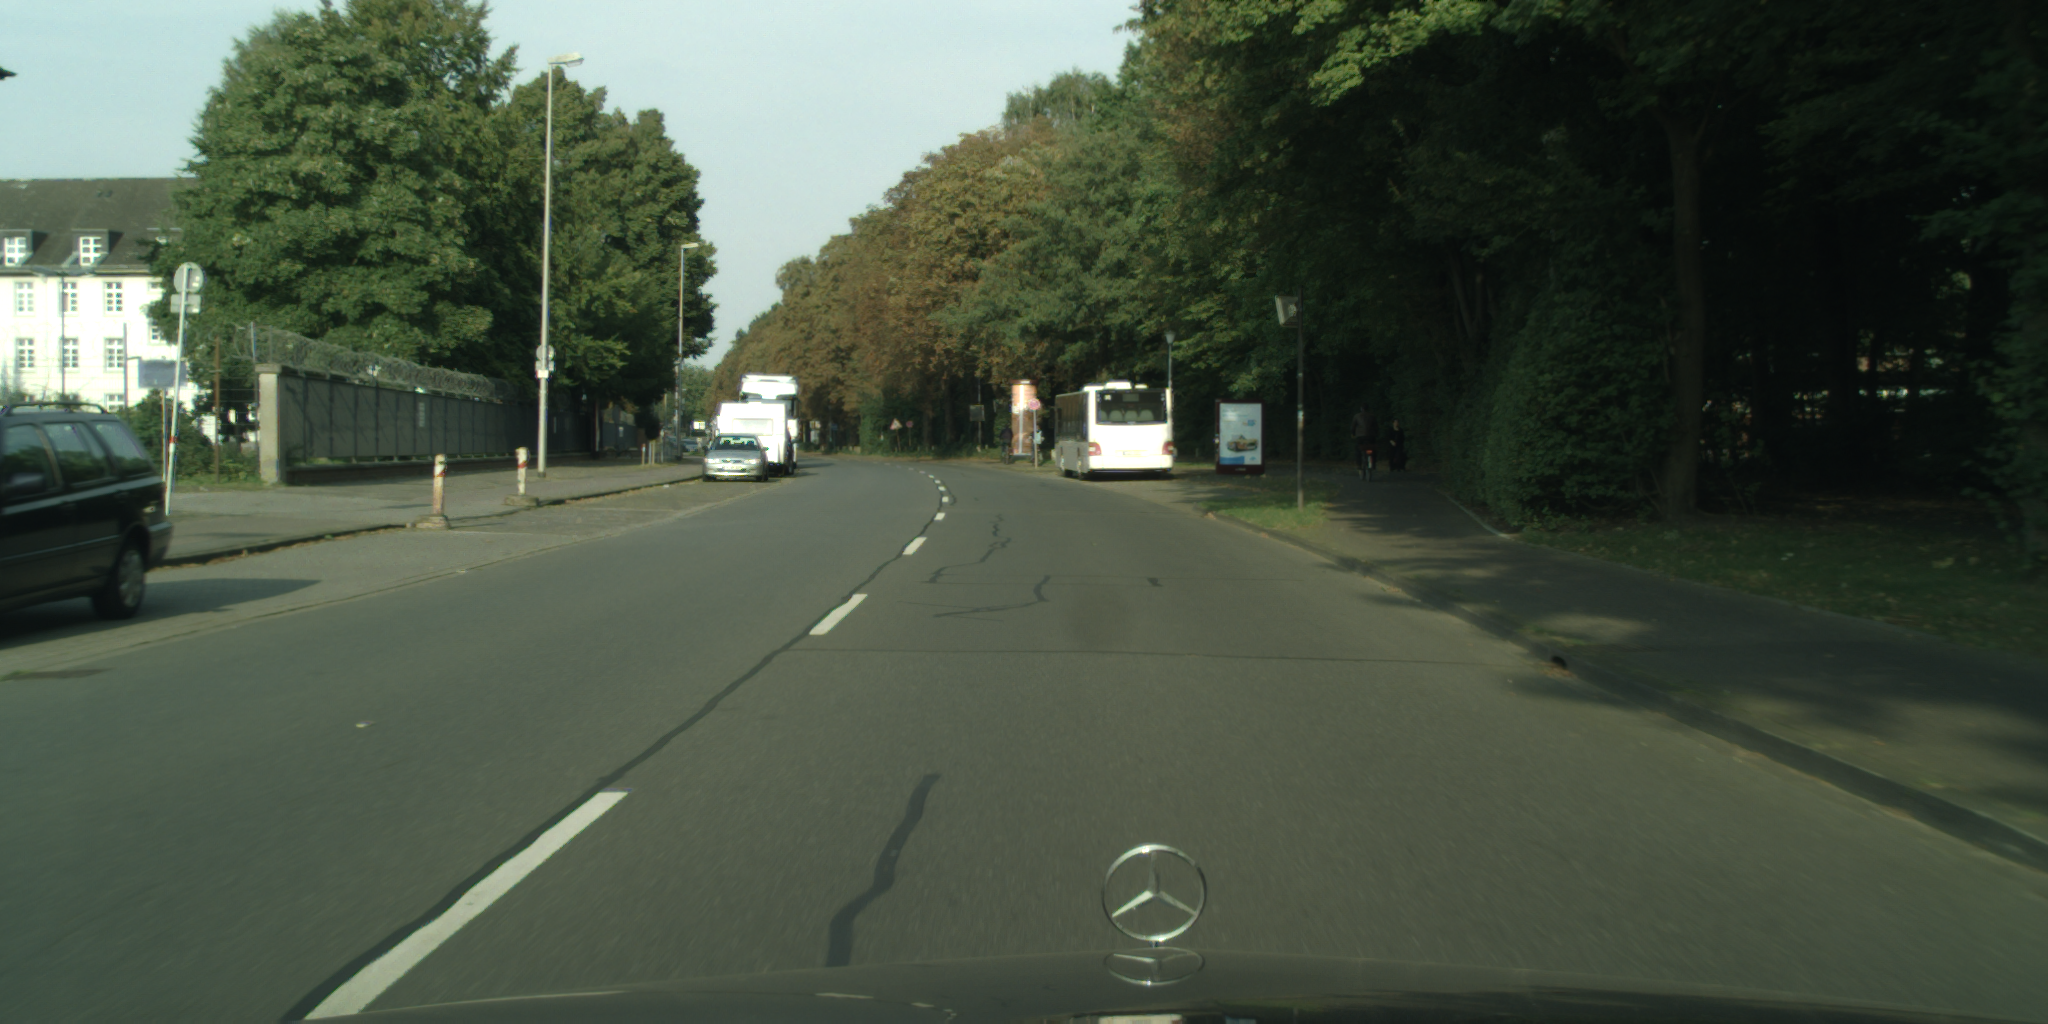

In [36]:
## check again
i = 0
img_name = imgs_test[i]
img_path = imgs_path_test + img_name
img_raw = Image.open(img_path)
img, anno = dataset_test[i]
convert_back(img, img_raw)

### Predicted

In [37]:
def show(i, imgs_test, threshold=.3):
    img_name = imgs_test[i]
    bboxes_gt = anno_test[img_name]

    img_path = imgs_path_test + img_name
    img = Image.open(img_path)
    np_image = np.array(img)
    img_raw = img

    ## idx = indices.index(i) # if on train set to unpermute
    img, anno = dataset_test[i]

    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
        
    preds = prediction['boxes'] # predicted bboxes
    preds = preds.cpu().data.numpy() # to numpy array
    
    scores = prediction['scores'] # scores of predicted bboxes
    scores = scores.cpu().data.numpy()
    
    ## keep only bboxes where score > threshold:
    highs = list(np.where(scores > threshold)[0])
    
    img = convert_back(img, img_raw)

    bboxes_x0x1y0y1 = []
    for high in highs:
        bboxes_x0x1y0y1.append(list(preds[high]))
        
    ## transform the bboxes from tensor to list and back to [x, y, w, h] format
    ## transform back to [x, y, w, h] format
    bboxes = []
    for bbox in bboxes_x0x1y0y1:
        bbox = list(bbox)
        x0, y0 = bbox[0], bbox[1]
        x1, y1 = bbox[2], bbox[3]

        bboxes.append([x0, y0, x1 - x0, y1 - y0])
    
    ## draw the predicted bounding boxes    
    plt.rcParams['figure.figsize'] = [12, 8]

    fig, ax = plt.subplots()

    ax.imshow(img);

    # bbox = [x, y, w, h]
    for bbox in bboxes:
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3], 
            linewidth=1, edgecolor='r', facecolor='none')

        ax.add_patch(rect)

    plt.title('Pedestrians detected')
    
    # bbox = [x, y, w, h]
    for bbox in bboxes_gt:
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3], 
            linewidth=1, edgecolor='g', facecolor='none')

        ax.add_patch(rect)    
    
    plt.show()

img shape: 1024 x 2048 x 3
Image was flipped: False


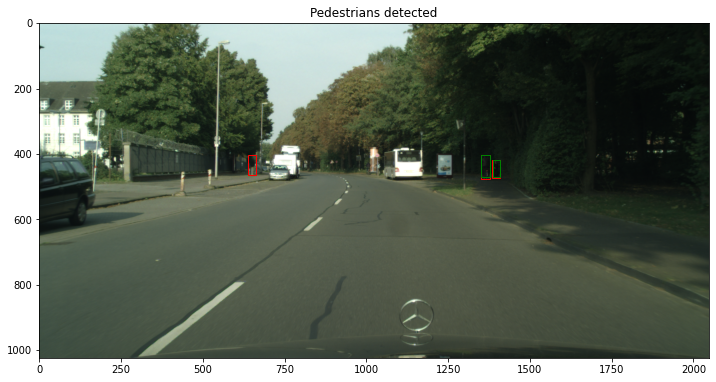

In [38]:
show(0, imgs_test)

## Export for testing

In [39]:
def save_model(model, path="./models/entire_model.pt"):
    torch.save(model, path)
    print('Model saved to ' + path)

In [40]:
save_model(model, path="../data/models/final-model-fit.pt")

Model saved to ../data/models/final-model-fit.pt


In [41]:
# def load_model(path="./models/entire_model.pt"):
#     if torch.cuda.is_available():
#         return torch.load(path)
#     else:
#         return torch.load(path, map_location=torch.device('cpu'))
# model = load_model(path="../data/models/final-model-fit.pt")    

For testing we are using Citypersons validation set of 500 images and corresponding annotations in particular 441 images where there are persons on the images. From cities: Munster, Frankfurt, Lindau.

For the first export of predictions, I used the model I build on only 152 images from Aachen, which is a small subset of training set of Citypersons dataset. For final test, I trained it on the complete training set and used the complete test set of 500 images.

In [42]:
len(dataset_test), len(imgs_test)

(418, 418)

In [43]:
tstart = time.time()
# put the model in evaluation mode
model.eval()

predictions = {}
for i in range(len(dataset_test)):
    img, anno = dataset_test[i]

    with torch.no_grad():
        prediction = model([img.to(device)])[0]
        predictions[imgs_test[i]] = prediction
        
    print('.', end = '')

tend = time.time()
print('\nExported %d predictions' % (len(predictions)))
print('\nTime elapsed = %.2f min' % ((tend - tstart)/60))

..................................................................................................................................................................................................................................................................................................................................................................................................................................
Exported 418 predictions

Time elapsed = 1.04 min


In [44]:
predictions2 = {}
for img in imgs_test:
    pred = predictions[img]
    boxes, labels, scores = pred['boxes'], pred['labels'], pred['scores']
    predictions2[img] = {
        'boxes': boxes.cpu().detach().numpy(),
        'labels': labels.cpu().detach().numpy(),
        'scores': scores.cpu().detach().numpy(),
    }

In [48]:
import pickle
with open(r"../data/predictions-final.pickle", "wb") as output_file:
    pickle.dump(predictions2, output_file)